In [1]:
from utils.plotter import get_roc_curves_from_df
from utils.wandb_calls import fetch_files_from_runs
from utils import bad_runs
import os
import pandas as pd
import pickle
import shutil

### Download

In [2]:
# for folder in os.listdir("./results/"):
#     if "acdc" in folder:# or "sp" in folder:
#         shutil.rmtree(f"./results/{folder}")


In [3]:
# project = "circuit_discovery"
# group = "acdc"
# files_to_fetch = ["result.pkl"]
# fetch_files_from_runs(project, group=group, files_to_download=files_to_fetch)

100%|██████████| 2343/2343 [04:12<00:00,  9.28it/s] 


### ROC

In [4]:
from utils.get_circuit_discovery_scores import walk_dirs_and_get_scores
import pandas as pd
from utils import bad_runs
bad_runs = ['38', '16', # these are constant runs
            '35', '37',# '4', # these are runs for which I haven't saved the model on wandb for one of siit or iit
            '34', '36', '18'
]
# walk_dirs_and_get_scores("acdc")
acdc_510_scores = walk_dirs_and_get_scores(weight=510, algorithm="acdc")
node_sp_510_scores = walk_dirs_and_get_scores(weight=510, algorithm="node_sp")
edge_sp_510_scores = walk_dirs_and_get_scores(weight=510, algorithm="edge_sp")

/Users/cybershiptrooper/src/interpretability/MATS/circuits-benchmark/notebooks/utils/get_circuit_discovery_scores.py:25: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([
/Users/cybershiptrooper/src/interpretability/MATS/circuits-benchmark/notebooks/utils/get_circuit_discovery_scores.py:25: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([


results/acdc_35/weight_510
results/acdc_34/weight_510
results/acdc_33/weight_510
Skipping 4
results/acdc_18/weight_510
results/acdc_11/weight_510
Skipping 16
results/acdc_19/weight_510
Skipping 38
results/acdc_37/weight_510
results/acdc_8/weight_510
results/acdc_7/weight_510
Skipping 7 0.0
Skipping 7 0.1
Skipping 7 0.8
Skipping 7 1e-05
Skipping 7 0.025
Skipping 7 100.0
Skipping 7 0.001
Skipping 7 10.0
Skipping 7 50.0
Skipping 7 0.01
Skipping 7 0.0001
Skipping 7 0.2
Skipping 7 0.5
Skipping 7 20.0
Skipping 7 1.0
Skipping 7 0.05
results/acdc_24/weight_510
results/acdc_13/weight_510
results/acdc_14/weight_510
Skipping 14 0.0
Skipping 14 0.1
Skipping 14 0.8
Skipping 14 1e-05
Skipping 14 0.025
Skipping 14 100.0
Skipping 14 0.001
Skipping 14 10.0
Skipping 14 50.0
Skipping 14 0.01
Skipping 14 0.0001
Skipping 14 0.2
Skipping 14 0.5
Skipping 14 20.0
Skipping 14 1.0
Skipping 14 0.05
results/node_sp_35/weight_510
results/node_sp_34/weight_510
results/node_sp_33/weight_510
results/node_sp_8/weight_

/Users/cybershiptrooper/src/interpretability/MATS/circuits-benchmark/notebooks/utils/get_circuit_discovery_scores.py:25: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([


Skipping 16
results/edge_sp_11/weight_510
results/edge_sp_18/weight_510
results/edge_sp_21/weight_510
results/edge_sp_19/weight_510
results/edge_sp_35/weight_510
results/edge_sp_33/weight_510
results/edge_sp_8/weight_510
results/edge_sp_34/weight_510


In [5]:
# edge_sp_510_scores

In [6]:
node_sp_510_scores["run"].unique(), acdc_510_scores["run"].unique()

(array(['35', '34', '33', '8', '11', '18', '19', '21', '36', '37', '3',
        '24', '13'], dtype=object),
 array(['35', '34', '33', '18', '11', '19', '37', '8', '24', '13'],
       dtype=object))

In [7]:
# from utils.plotter import pessimistic_auc as auc
from sklearn.metrics import auc

def make_fpr_tpr_monotonic(fpr_list, tpr_list):
    # return sorted fpr and corresponding tpr  (i.e., if fpr[i] -> fpr[j] then tpr[i] -> tpr[j])
    fpr_tpr = list(zip(fpr_list, tpr_list))
    fpr_tpr = sorted(fpr_tpr, key=lambda x: x[0])
    fpr_list, tpr_list = zip(*fpr_tpr)
    return list(fpr_list), list(tpr_list)

def get_ROCs(scores: pd.DataFrame, algorithm: str):
    if algorithm == "acdc":
        sort_key = "threshold"
        ascending = False
    elif "sp" in algorithm:
        sort_key = "lambda"
        ascending = True
    rocs = {} # run : {node: node_roc, edge: edge_roc}
    scores_by_run = scores.groupby("run")
    for run, run_scores in scores_by_run:
        run_scores = run_scores.sort_values(by=sort_key, ascending=ascending)
        # get 'node_tpr', 'node_fpr', 'edge_tpr', 'edge_fpr' from run_scores
        node_fpr = list(run_scores["node_fpr"].values.copy())
        node_tpr = list(run_scores["node_tpr"].values.copy())
        edge_fpr = list(run_scores["edge_fpr"].values.copy())
        edge_tpr = list(run_scores["edge_tpr"].values.copy())
        # print(node_fpr, node_tpr)
        # make fpr and tpr lists monotonic
        node_fpr, node_tpr = make_fpr_tpr_monotonic(node_fpr, node_tpr)
        edge_fpr, edge_tpr = make_fpr_tpr_monotonic(edge_fpr, edge_tpr)

        # calculate roc_auc for node and edge
        try:
            node_roc = auc(node_fpr, node_tpr)
            edge_roc = auc(edge_fpr, edge_tpr)
        except:
            print(f"error in run {run}")
            continue
        rocs[run] = {"node": node_roc, "edge": edge_roc}
    return rocs

In [8]:
from utils.get_circuit_discovery_scores import append_row
# make 2 combined dataframes: one for node_roc and one for edge_roc

def get_combined_roc_dfs(acdc_rocs, node_sp_rocs):
    node_roc_df = pd.DataFrame()
    edge_roc_df = pd.DataFrame()

    for k, v in acdc_rocs.items():
        run = k
        acdc_node_roc = v["node"]
        acdc_edge_roc = v["edge"]
        try:
            node_sp_node_roc = node_sp_rocs[k]["node"]
            node_sp_edge_roc = node_sp_rocs[k]["edge"]
        except:
            continue
        node_entry = {"run": run, "acdc": acdc_node_roc, "node_sp": node_sp_node_roc}
        edge_entry = {"run": run, "acdc": acdc_edge_roc, "node_sp": node_sp_edge_roc}
        node_roc_df = append_row(node_roc_df, pd.Series(node_entry))
        edge_roc_df = append_row(edge_roc_df, pd.Series(edge_entry))

    return node_roc_df, edge_roc_df


def get_combined_roc_df_from_list(list_of_rocs, list_of_names):
    node_roc_df = pd.DataFrame()
    edge_roc_df = pd.DataFrame()

    for k, v in list_of_rocs[0].items():
        run = k
        node_roc = v["node"]
        edge_roc = v["edge"]
        node_entry = {"run": run, list_of_names[0]: node_roc}
        edge_entry = {"run": run, list_of_names[0]: edge_roc}
        for i, rocs in enumerate(list_of_rocs[1:]):
            try:
                node_roc = rocs[k]["node"]
                edge_roc = rocs[k]["edge"]
            except:
                continue
            node_entry[list_of_names[i+1]] = node_roc
            edge_entry[list_of_names[i+1]] = edge_roc
        node_roc_df = append_row(node_roc_df, pd.Series(node_entry))
        edge_roc_df = append_row(edge_roc_df, pd.Series(edge_entry))
    

    return node_roc_df, edge_roc_df

In [9]:
acdc_rocs = get_ROCs(acdc_510_scores, "acdc")
node_sp_rocs = get_ROCs(node_sp_510_scores, "node_sp")
edge_sp_rocs = get_ROCs(edge_sp_510_scores, "edge_sp")
node_roc_df_510, edge_roc_df_510 = get_combined_roc_dfs(acdc_rocs, node_sp_rocs)

In [10]:
node_roc_df, edge_roc_df = get_combined_roc_df_from_list([acdc_rocs, node_sp_rocs, edge_sp_rocs], ["acdc", "node_sp", "edge_sp"])

In [11]:
node_roc_df

,run,acdc,node_sp,edge_sp
0,11,1.000000,0.875000,0.750000
1,13,1.000000,1.000000,1.000000
2,18,0.875000,1.000000,0.750000
3,19,0.937500,0.375000,0.250000
4,24,0.944444,0.777778,0.777778
5,33,0.833333,0.444444,0.333333
6,34,0.888889,0.444444,0.333333
7,35,0.666667,0.555556,0.333333
8,37,0.722222,0.111111,0.111111
9,8,0.750000,0.354167,0.000000


In [12]:
acdc_tracr_scores = walk_dirs_and_get_scores(weight="tracr", algorithm="acdc")
node_sp_tracr_scores = walk_dirs_and_get_scores(weight="tracr", algorithm="node_sp")
edge_sp_tracr_scores = walk_dirs_and_get_scores(weight="tracr", algorithm="edge_sp")

results/acdc_35/weight_tracr
results/acdc_34/weight_tracr
results/acdc_33/weight_tracr
results/acdc_3/weight_tracr
Skipping 4
results/acdc_18/weight_tracr
results/acdc_11/weight_tracr
Skipping 16
results/acdc_28/weight_tracr
results/acdc_19/weight_tracr
Skipping 19 0.0
Skipping 19 0.1
Skipping 19 0.8
Skipping 19 1e-05
Skipping 19 0.025
Skipping 19 100.0
Skipping 19 0.001
Skipping 19 10.0
Skipping 19 50.0
Skipping 19 0.01
Skipping 19 0.0001
Skipping 19 0.2
Skipping 19 0.5
Skipping 19 20.0
Skipping 19 1.0
Skipping 19 0.05
results/acdc_21/weight_tracr
Skipping 38
results/acdc_36/weight_tracr
results/acdc_37/weight_tracr
results/acdc_8/weight_tracr
Skipping 8 0.0
Skipping 8 0.1
Skipping 8 0.8
Skipping 8 1e-05
Skipping 8 0.025
Skipping 8 100.0
Skipping 8 0.001
Skipping 8 10.0
Skipping 8 50.0
Skipping 8 0.01
Skipping 8 0.0001
Skipping 8 0.2
Skipping 8 0.5
Skipping 8 20.0
Skipping 8 1.0
Skipping 8 0.05
results/acdc_1/weight_tracr
Skipping 1 0.0
Skipping 1 0.1
Skipping 1 0.8
Skipping 1 1e-05
S

/Users/cybershiptrooper/src/interpretability/MATS/circuits-benchmark/notebooks/utils/get_circuit_discovery_scores.py:25: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([
/Users/cybershiptrooper/src/interpretability/MATS/circuits-benchmark/notebooks/utils/get_circuit_discovery_scores.py:25: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([
/Users/cybershiptrooper/src/interpretability/MATS/circuits-benchmark/notebooks/utils/get_circuit_discovery_scores.py:25: FutureW

In [13]:
import numpy as np
def p_auc(xs, ys):
    # Sort indices based on 'x' and 'y'
    i = np.lexsort(
        (ys, xs)
    )  # lexsort sorts by the last column first, then the second last, etc., i.e we firstly sort by x and then y to break ties

    xs = np.array(xs, dtype=np.float64)[i]
    ys = np.array(ys, dtype=np.float64)[i]

    # remove x and y values where y is not increasing
    while True:
        indices_to_remove = []
        for i in range(1, len(ys)):
            if ys[i] < ys[i - 1]:
                indices_to_remove.append(i)
        if len(indices_to_remove) == 0:
            break
        for i in indices_to_remove[::-1]:
            xs = np.delete(xs, i)
            ys = np.delete(ys, i)
    # prepend 0 to xs and ys
    xs = np.concatenate([[0], xs])
    ys = np.concatenate([[0], ys])

    dys = np.diff(ys)

    print("xs", xs)
    print("ys", ys)
    print("dys", dys)

    assert np.all(np.diff(xs) >= 0), "not sorted"
    assert np.all(dys >= 0), "not monotonically increasing"

    # The slabs of the stairs
    area = np.sum((1 - xs)[1:] * dys)
    return area

In [14]:
# from utils.plotter import pessimistic_auc as p_auc
from sklearn.metrics import auc
df_8 = edge_sp_tracr_scores.groupby('run').get_group('3').sort_values(by='node_fpr', ascending=True)
ntprs_8 = df_8['node_tpr'].values
nfprs_8 = df_8['node_fpr'].values

auc_8 = auc(nfprs_8, ntprs_8)
p_auc_8 = p_auc(nfprs_8, ntprs_8)
print("fprs:", nfprs_8)
print("tprs:", ntprs_8)
print("auc:", auc_8)
print("pessimistic auc:", p_auc_8)

xs [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.5]
ys [0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
dys [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
fprs: [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.5]
tprs: [1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 1. 1.]
auc: 0.5
pessimistic auc: 1.0


In [15]:
acdc_tracr_rocs = get_ROCs(acdc_tracr_scores, "acdc")
node_sp_tracr_rocs = get_ROCs(node_sp_tracr_scores, "node_sp")
edge_sp_tracr_rocs = get_ROCs(edge_sp_tracr_scores, "edge_sp")

error in run 28


In [16]:
node_roc_df_tracr, edge_roc_df_tracr = get_combined_roc_dfs(acdc_tracr_rocs, node_sp_tracr_rocs)

In [17]:
node_roc_df_tracr

,run,acdc,node_sp
0,11,1.0,0.416667
1,13,1.0,0.800000
2,18,0.9,1.000000
3,21,1.0,0.725000
4,24,1.0,0.000000
5,3,1.0,0.416667
6,33,1.0,1.000000
7,34,1.0,1.000000
8,35,1.0,1.000000
9,36,1.0,1.000000


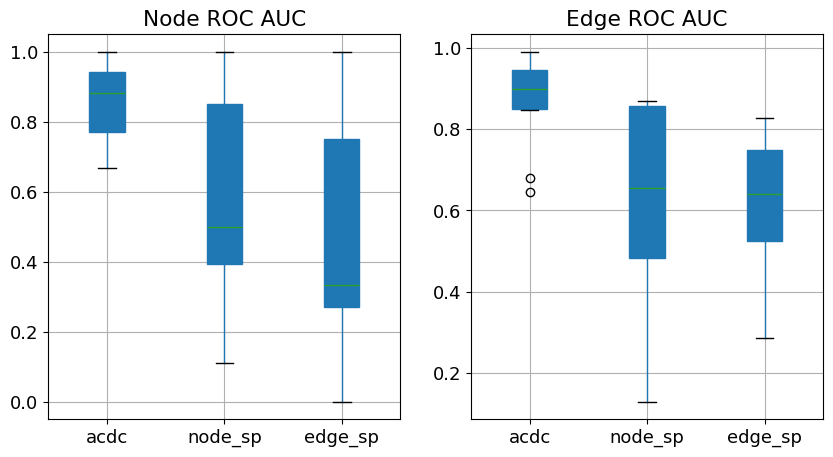

In [18]:
# make box plots for node and edge roc_auc
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

node_roc_df.boxplot(ax=ax[0], 
                    column=["acdc", "node_sp", "edge_sp"],
                    patch_artist=True,
                    showfliers=True,
                    # whis=[5, 95],
                    )
edge_roc_df.boxplot(ax=ax[1],
                    column=["acdc", "node_sp", "edge_sp"],
                    patch_artist=True,
                    showfliers=True,
                    # whis=[5, 95],
                    )
# set title
ax[0].set_title("Node ROC AUC")
ax[1].set_title("Edge ROC AUC")
plt.savefig("plots/acdc_vs_node_sp_vs_edge_sp_roc_auc_boxplot.pdf", bbox_inches='tight', dpi=600, format='pdf')

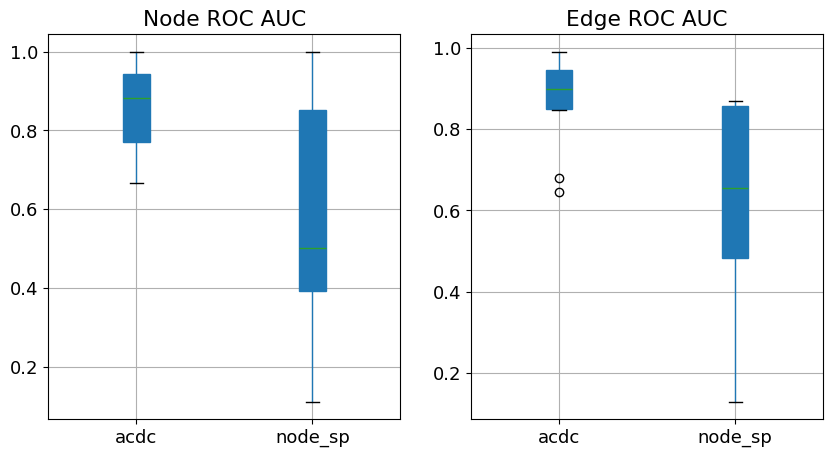

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

node_roc_df_510.boxplot(ax=ax[0],
                    column=["acdc", "node_sp"], 
                    patch_artist=True,
                    showfliers=True,
                    # whis=[5, 95],
                    )

edge_roc_df_510.boxplot(ax=ax[1],
                    column=["acdc", "node_sp"], 
                    patch_artist=True,
                    showfliers=True,
                    # whis=[5, 95],
                    )
# set title
ax[0].set_title("Node ROC AUC")
ax[1].set_title("Edge ROC AUC")

plt.savefig("plots/acdc_vs_node_sp.pdf", format="pdf", bbox_inches="tight", dpi=600)

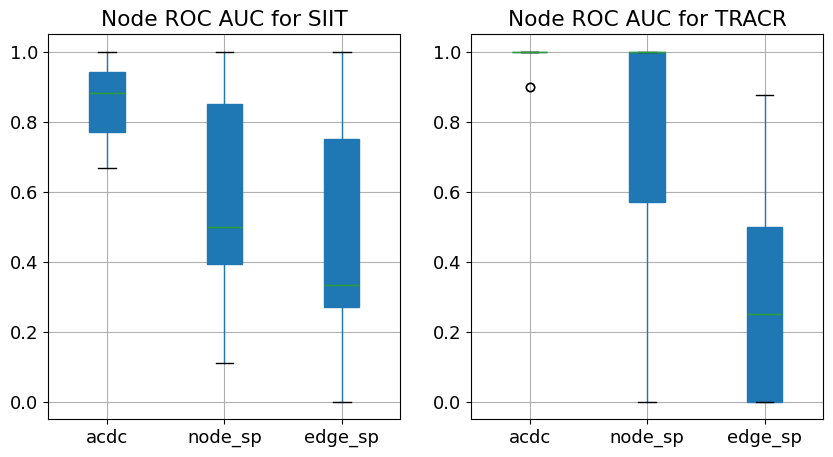

In [20]:
# make box plots for node and edge roc_auc
import matplotlib.pyplot as plt

combined_df_510_nodes, combined_df_510_edges = get_combined_roc_df_from_list([acdc_rocs, node_sp_rocs, edge_sp_rocs], ["acdc", "node_sp", "edge_sp"])
combined_df_tracr_nodes, combined_df_tracr_edges = get_combined_roc_df_from_list([acdc_tracr_rocs, node_sp_tracr_rocs, edge_sp_tracr_rocs], ["acdc", "node_sp", "edge_sp"])

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
combined_df_510_nodes.boxplot(ax=ax[0],
                    column=["acdc", "node_sp", "edge_sp"],
                    patch_artist=True,
                    showfliers=True,
                    # whis=[5, 95],
                    )
combined_df_tracr_nodes.boxplot(ax=ax[1],
                    column=["acdc", "node_sp", "edge_sp"],
                    patch_artist=True,
                    showfliers=True,
                    # whis=[5, 95],
                    )


ax[0].set_title("Node ROC AUC for SIIT")
ax[1].set_title("Node ROC AUC for TRACR")
plt.savefig("plots/tracr_vs_siit_node_roc.pdf", format="pdf", bbox_inches="tight", dpi=600)

Text(0.5, 1.0, 'Node ROC AUC for TRACR')

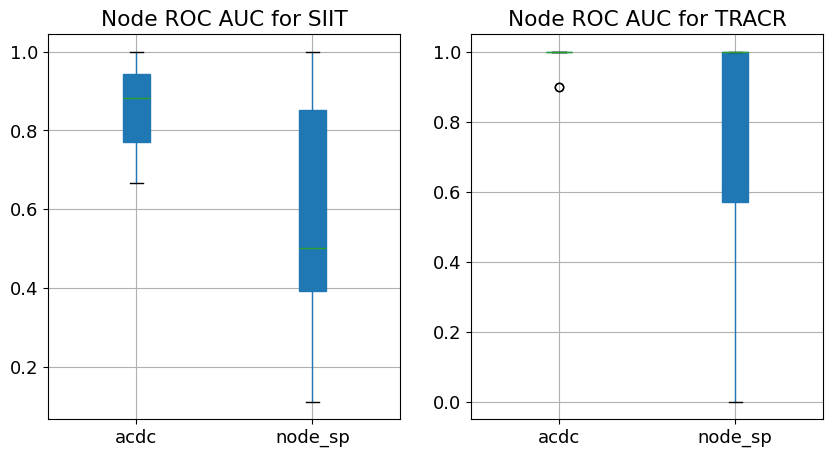

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
combined_df_510_nodes.boxplot(ax=ax[0],
                    column=["acdc", "node_sp"],
                    patch_artist=True,
                    showfliers=True,
                    # whis=[5, 95],
                    )
combined_df_tracr_nodes.boxplot(ax=ax[1],
                    column=["acdc", "node_sp"],
                    patch_artist=True,
                    showfliers=True,
                    # whis=[5, 95],
                    )


ax[0].set_title("Node ROC AUC for SIIT")
ax[1].set_title("Node ROC AUC for TRACR")

### Realism

In [22]:
from utils.get_circuit_discovery_scores import get_realism_scores
acdc_510_realism = get_realism_scores(weight=510, algorithm="acdc")
node_sp_510_realism = get_realism_scores(weight=510, algorithm="node_sp")
edge_sp_510_realism = get_realism_scores(weight=510, algorithm="edge_sp")

/Users/cybershiptrooper/src/interpretability/MATS/circuits-benchmark/notebooks/utils/get_circuit_discovery_scores.py:25: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([
/Users/cybershiptrooper/src/interpretability/MATS/circuits-benchmark/notebooks/utils/get_circuit_discovery_scores.py:25: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([
/Users/cybershiptrooper/src/interpretability/MATS/circuits-benchmark/notebooks/utils/get_circuit_discovery_scores.py:25: FutureW

In [23]:
from utils.realism_helper import get_best_score, make_combined_realism_df

In [24]:
# # reload module
# import utils.realism_helper as realism_helper
# from importlib import reload
# reload(realism_helper) 
# reload(realism_helper)

In [25]:
acdc_510_best_realism = get_best_score(acdc_510_realism)
node_sp_510_best_realism = get_best_score(node_sp_510_realism)
edge_sp_510_best_realism = get_best_score(edge_sp_510_realism)

In [26]:
combined_realism_df_510 = make_combined_realism_df(acdc_510_best_realism, node_sp_510_best_realism)
combined_realism_df_510

Node sp realism not found for run 7


,run,acdc,node_sp
0,11,0.474224,0.436851
1,13,0.492938,0.492940
2,14,0.348224,0.347938
3,18,0.554870,0.553243
4,19,0.614568,0.614568
5,24,0.590546,0.400278
6,33,0.735815,0.661292
7,34,0.549932,0.549932
8,35,0.212154,0.212064
9,37,0.237088,0.212607


In [27]:
import pandas as pd
from utils.get_circuit_discovery_scores import append_row
def make_combined_realism_df_from_list(list_of_realism_dfs, list_of_labels):
    # check if labels are unique
    assert len(list_of_labels) == len(set(list_of_labels)), "Labels are not unique"
    combined_realism_df = pd.DataFrame()
    for k, v in list_of_realism_dfs[0].items():
        run = k
        realism_entry = v
        realism_label = list_of_labels[0]
        entry = {"run": run, realism_label: realism_entry}
        for i in range(1, len(list_of_realism_dfs)):
            realism_entry = list_of_realism_dfs[i][k]
            realism_label = list_of_labels[i]
            entry[realism_label] = realism_entry
        
        combined_realism_df = append_row(combined_realism_df, pd.Series(entry))
    return combined_realism_df

In [28]:
acdc_110_realism = get_realism_scores(weight="110", algorithm="acdc")

/Users/cybershiptrooper/src/interpretability/MATS/circuits-benchmark/notebooks/utils/get_circuit_discovery_scores.py:25: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([


In [29]:
acdc_100_realism = get_realism_scores(weight="100", algorithm="acdc")
acdc_tracr_realism = get_realism_scores(weight="tracr", algorithm="acdc")
acdc_100_best_realism = get_best_score(acdc_100_realism)
acdc_tracr_best_realism = get_best_score(acdc_tracr_realism)

node_sp_100_realism = get_realism_scores(weight="100", algorithm="node_sp")
node_sp_tracr_realism = get_realism_scores(weight="tracr", algorithm="node_sp")
node_sp_100_best_realism = get_best_score(node_sp_100_realism)
node_sp_tracr_best_realism = get_best_score(node_sp_tracr_realism)

edge_sp_100_realism = get_realism_scores(weight="100", algorithm="edge_sp")
edge_sp_tracr_realism = get_realism_scores(weight="tracr", algorithm="edge_sp")
edge_sp_100_best_realism = get_best_score(edge_sp_100_realism)
edge_sp_tracr_best_realism = get_best_score(edge_sp_tracr_realism)


/Users/cybershiptrooper/src/interpretability/MATS/circuits-benchmark/notebooks/utils/get_circuit_discovery_scores.py:25: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([
/Users/cybershiptrooper/src/interpretability/MATS/circuits-benchmark/notebooks/utils/get_circuit_discovery_scores.py:25: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([
/Users/cybershiptrooper/src/interpretability/MATS/circuits-benchmark/notebooks/utils/get_circuit_discovery_scores.py:25: FutureW

In [30]:
k_510 = set(acdc_510_best_realism.keys())
k_100 = set(acdc_100_best_realism.keys())
k_tracr = set(acdc_tracr_best_realism.keys())

common_keys = k_510.intersection(k_100).intersection(k_tracr)

for k in k_510:
    if k not in common_keys:
        # remove from acdc_510_best_realism
        acdc_510_best_realism.pop(k)

for k in k_100:
    if k not in common_keys:
        # remove from acdc_100_best_realism
        acdc_100_best_realism.pop(k)

for k in k_tracr:
    if k not in common_keys:
        # remove from acdc_tracr_best_realism
        acdc_tracr_best_realism.pop(k)


In [34]:
combined_realism_df = make_combined_realism_df_from_list(
    [acdc_tracr_best_realism, acdc_100_best_realism, acdc_510_best_realism],
    ["tracr", "natural", "SIIT"]
)

combined_realism_df

,run,tracr,natural,SIIT
0,11,0.436851,0.449420,0.474224
1,13,0.493942,0.674353,0.492938
2,14,0.249662,0.348222,0.348224
3,18,0.553243,0.571170,0.554870
4,19,0.415903,0.614568,0.614568
5,24,1.000000,0.587903,0.590546
6,33,0.661292,0.661292,0.735815
7,34,0.549932,0.437564,0.549932
8,35,0.214126,0.252555,0.212154
9,37,0.214126,0.287402,0.237088


Text(0.5, 1.0, 'Realism scores')

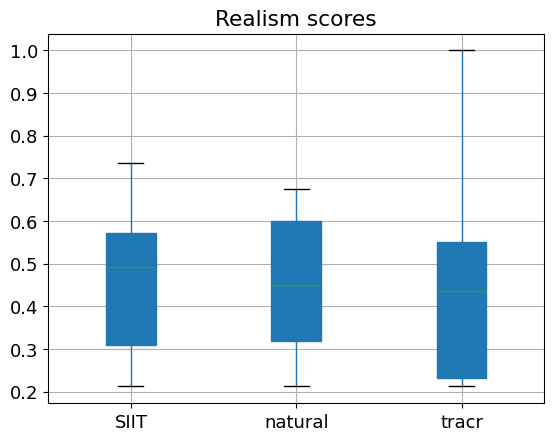

In [35]:
# plot realism score for 510, 100 and tracr
import matplotlib.pyplot as plt

combined_realism_df.boxplot(ax=plt.gca(),
                    column=["SIIT", "natural", "tracr"],
                    patch_artist=True,
                    showfliers=True,
                    # whis=[5, 95],
                    )

plt.title("Realism scores")


Node sp realism not found for run 11
Node sp realism not found for run 13
Node sp realism not found for run 14
Node sp realism not found for run 18
Node sp realism not found for run 19
Node sp realism not found for run 21
Node sp realism not found for run 24
Node sp realism not found for run 3
Node sp realism not found for run 33
Node sp realism not found for run 34
Node sp realism not found for run 35
Node sp realism not found for run 36
Node sp realism not found for run 37
Node sp realism not found for run 8
Node sp realism not found for run 7


ValueError: boxplot method requires numerical columns, nothing to plot.

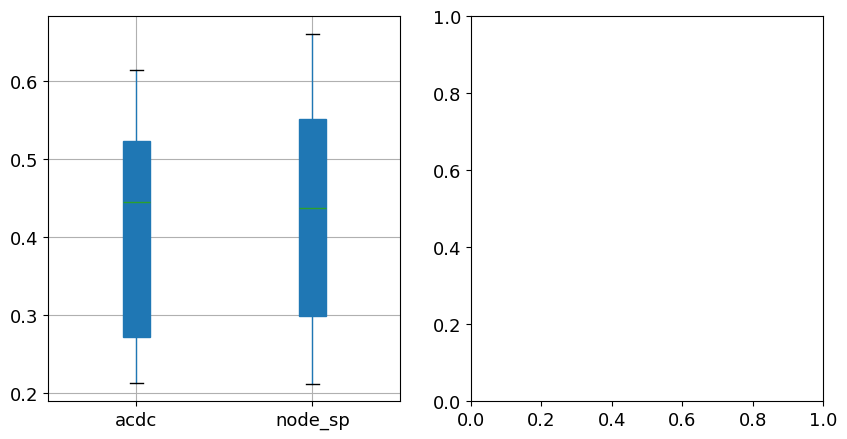

In [33]:
node_sp_100_mean_realism = get_best_score(node_sp_100_realism, mean=True)
acdc_100_mean_realism = get_best_score(acdc_100_realism, mean=True)
node_sp_510_mean_realism = get_best_score(node_sp_510_realism, mean=True)
acdc_510_mean_realism = get_best_score(acdc_510_realism, mean=True)

combined_realism_df_100_mean = make_combined_realism_df(acdc_100_mean_realism, node_sp_100_mean_realism)
combined_realism_df_510_mean = make_combined_realism_df(acdc_510_mean_realism, node_sp_510_mean_realism)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

combined_realism_df_510_mean.boxplot(ax=ax[0],
                    column=["acdc", "node_sp"], 
                    patch_artist=True,
                    showfliers=True,
                    # whis=[5, 95],
                    )

combined_realism_df_100_mean.boxplot(ax=ax[1],
                    column=["acdc", "node_sp"], 
                    patch_artist=True,
                    showfliers=True,
                    # whis=[5, 95],
                    )

ax[0].set_title("Mean Realism Scores for Weight SIIT")
ax[1].set_title("Mean Realism Scores for Weight Natural Model")


Text(0.5, 1.0, 'Realism Scores for Weight tracr')

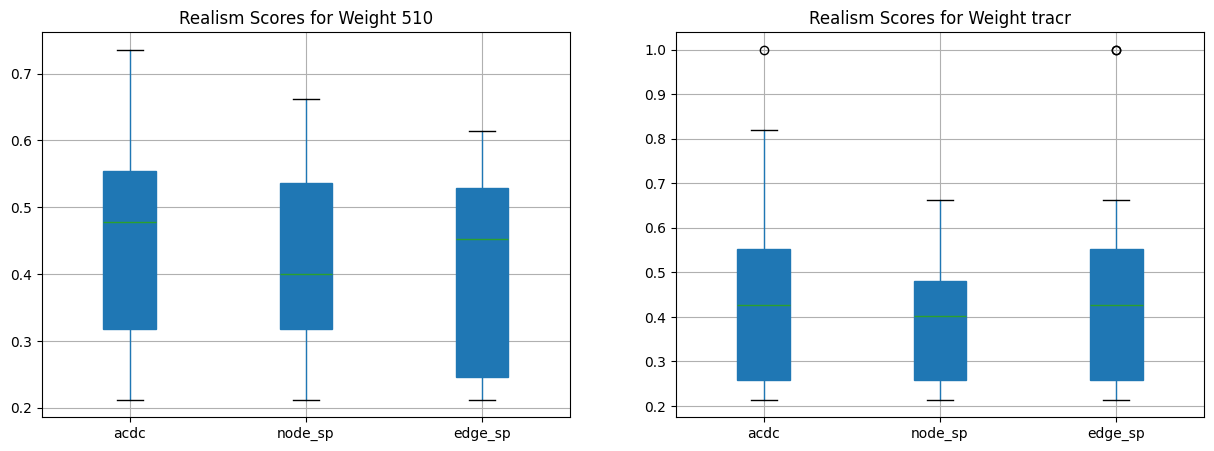

In [ ]:
combined_realism_510 = make_combined_realism_df_from_list([
    acdc_510_best_realism, node_sp_510_best_realism, edge_sp_510_best_realism
], ["acdc", "node_sp", "edge_sp"])

# combined_realism_100 = make_combined_realism_df_from_list([
#     acdc_100_best_realism, node_sp_100_best_realism, edge_sp_100_best_realism
# ], ["acdc", "node_sp", "edge_sp"])

combined_realism_tracr = make_combined_realism_df_from_list([
    acdc_tracr_best_realism, node_sp_tracr_best_realism, edge_sp_tracr_best_realism
], ["acdc", "node_sp", "edge_sp"])

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

combined_realism_510.boxplot(ax=ax[0],
                    column=["acdc", "node_sp", "edge_sp"],
                    patch_artist=True,
                    showfliers=True,
                    # whis=[5, 95],
                    )
# combined_realism_100.boxplot(ax=ax[1],
#                     column=["acdc", "node_sp", "edge_sp"],
#                     patch_artist=True,
#                     showfliers=True,
#                     # whis=[5, 95],
#                     )
combined_realism_tracr.boxplot(ax=ax[1],
                    column=["acdc", "node_sp", "edge_sp"],
                    patch_artist=True,
                    showfliers=True,
                    # whis=[5, 95],
                    )

ax[0].set_title("Realism Scores for Weight 510")
ax[1].set_title("Realism Scores for Weight tracr")
# ax[2].set_title("Realism Scores for Weight tracr")

In [ ]:
combined_realism_df_510_mean, combined_realism_df_100_mean

(  run      acdc   node_sp
 0  11  0.474224  0.436851
 1  13  0.492938  0.492940
 2  21  0.590546  0.400278
 3  24  0.590546  0.400278
 4   3  0.307617  0.307617
 5   8  0.269310  0.249977,
   run      acdc   node_sp
 0  11  0.474224  0.436851
 1  13  0.492938  0.492940
 2  21  0.590546  0.400278
 3  24  0.590546  0.400278
 4   3  0.307617  0.307617
 5   8  0.269310  0.249977)